This file is the code for training the chroma features using the custom-built CNN. **For a step-by-step explanation, please move to music_genre_cnn_melody_spectrogram.ipynb. (Since the code is similar!)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
import os
seed = 12
np.random.seed(seed)

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 12

In [ ]:
competition_name = "andradaolteanu/gtzan-dataset-music-genre-classification"

# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"

! pip install kaggle --quiet

In [ ]:
! mkdir ~/.kaggle
! cp {kaggle_creds_path} ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d {competition_name}

competition_name1 = "gtzan-dataset-music-genre-classification"
! mkdir kaggle_data
! unzip {competition_name1 + ".zip"} -d kaggle_data

# Unmount your Google Drive
drive.flush_and_unmount()

100% 1.21G/1.21G [00:58<00:00, 23.4MB/s]
100% 1.21G/1.21G [00:58<00:00, 22.3MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: kaggle_data/Data/features_30_sec.csv  
  inflating: kaggle_data/Data/features_3_sec.csv  
  inflating: kaggle_data/Data/genres_original/blues/blues.00000.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00001.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00002.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00003.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00004.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00005.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00006.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00007.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00008.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00009.wav  
  inflating: kaggle_data/Data/genres_original/blues/blues.00

In [ ]:
audio_fp = '/content/kaggle_data/Data/genres_original/classical/classical.00006.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

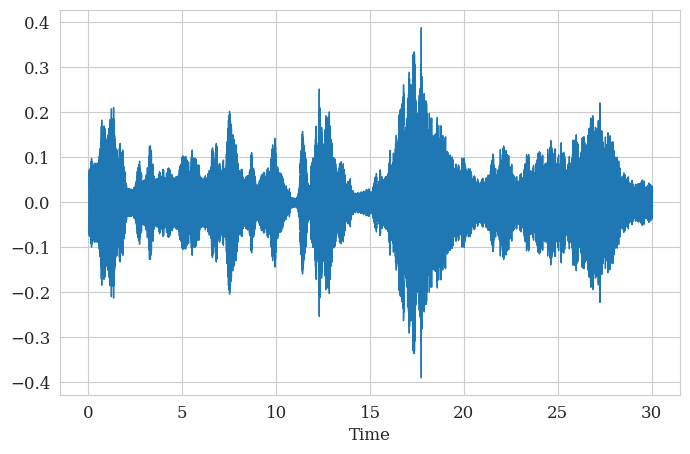

In [ ]:
# plot sample file
plt.figure(figsize=(8,5))
librosa.display.waveshow(audio_data, sr=sr)
plt.show()

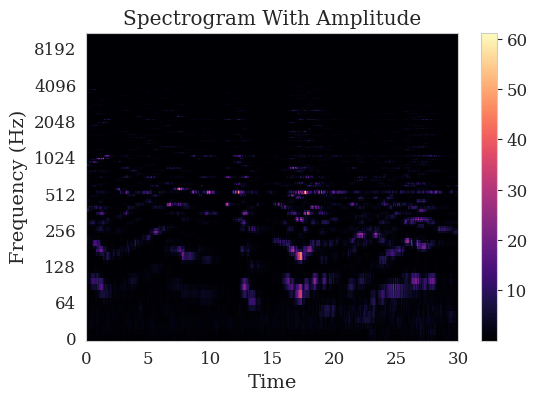

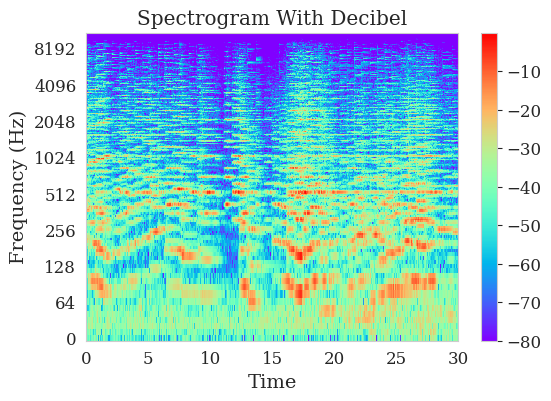

In [ ]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(6,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='log')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.colorbar()
plt.title("Spectrogram With Amplitude")
plt.show()

plt.figure(figsize=(6,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='rainbow')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.colorbar()
plt.title("Spectrogram With Decibel")
plt.show()

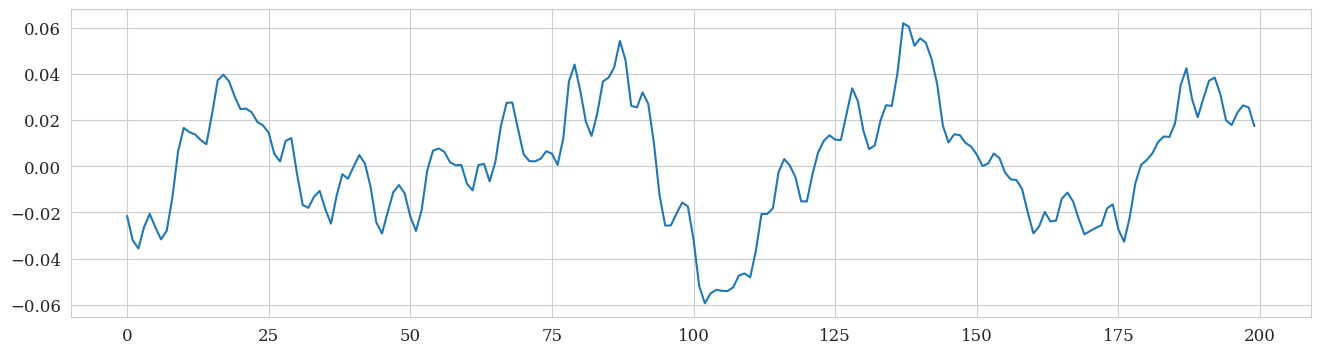

In [ ]:
# plot zoomed audio wave
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

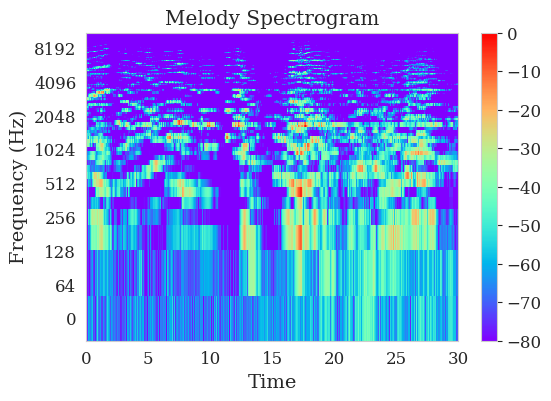

In [ ]:
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(6, 4))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='rainbow')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
plt.colorbar()
plt.title("Melody Spectrogram")
plt.show()

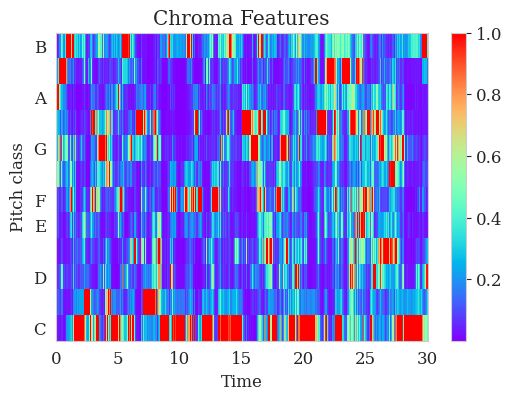

In [ ]:
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
plt.figure(figsize=(6, 4))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='rainbow')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

In [ ]:
def make_mel_spectrogram_df(directory, max_per_genre=50):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the
    same size, flattens them, and stores them in a dataframe.

    Genre labels are also computed and added to the dataframe.

    Parameters:
    directory (str): a directory containing audio files in .wav format

    Returns:
    df (DataFrame): a dataframe of flattened mel spectrograms and their
    corresponding genre labels
    '''

    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []

    # Looping through each file in the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            count = 0  # Initialize a counter for the files in this subdirectory
            dir_path = os.path.join(root, dir)

            for file in os.listdir(dir_path):
                if count >= max_per_genre:
                    break  # Stop reading more files in this directory if we've read 10
                if file.endswith(".wav"):
                    # print("file:", file)
                    count += 1  # Increment the counter for each .wav file
                    audio_path = os.path.join(dir_path, file)

                    try:
                        # Loading in the audio file
                        y, sr = librosa.load(audio_path)

                        # Extracting the label and adding it to the list
                        label = dir
                        labels.append(label)

                        # Computing the mel spectrograms
                        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
                        spect = librosa.power_to_db(spect, ref=np.max)

                        # Adjusting the size to be 128 x 660
                        if spect.shape[1] != 660:
                            spect.resize(128, 660, refcheck=False)
                        # Flattening to fit into dataframe and adding to the list
                        spect = spect.flatten()
                        mel_specs.append(spect)
                    except Exception as e:
                        print(f"Error processing {audio_path}: {str(e)}")

    # Converting the lists to arrays so we can stack them
    mel_specs = np.array(mel_specs)
    labels = np.array(labels).reshape(len(labels), 1)

    # Create dataframe
    df = pd.DataFrame(np.hstack((mel_specs, labels)), columns=[f"feature_{i}" for i in range(128*660)] + ["label"])

    return df

In [ ]:
def make_custom_spectrogram_df(directory, max_per_genre=50, n_fft=2048, hop_length=512):

    # Creating empty lists for custom spectrograms and labels
    labels = []
    custom_specs_db = []

    # Looping through each file in the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            count = 0  # Initialize a counter for the files in this subdirectory
            dir_path = os.path.join(root, dir)

            for file in os.listdir(dir_path):
                if count >= max_per_genre:
                    break  # Stop reading more files in this directory if we've read max_per_genre
                if file.endswith(".wav"):
                    # Increment the counter for each .wav file
                    count += 1
                    audio_path = os.path.join(dir_path, file)

                    try:
                        # Loading in the audio file
                        y, sr = librosa.load(audio_path)

                        # Extracting the label and adding it to the list
                        label = dir
                        labels.append(label)

                        # Computing the custom spectrogram with decibels
                        spec = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
                        spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)

                        # Adjusting the size to be 128 x 660
                        if spec_db.shape[1] != 660:
                            spec_db.resize(128, 660, refcheck=False)
                        # Flattening to fit into dataframe and adding to the list
                        spec_flat = spec_db.flatten()
                        custom_specs_db.append(spec_flat)
                    except Exception as e:
                        print(f"Error processing {audio_path}: {str(e)}")

    # Converting the lists to arrays so we can stack them
    custom_specs_db = np.array(custom_specs_db)
    labels = np.array(labels).reshape(len(labels), 1)

    # Create dataframe
    df = pd.DataFrame(np.hstack((custom_specs_db, labels)), columns=[f"feature_{i}" for i in range(128*660)] + ["label"])
    return df


In [ ]:
def make_chroma_feature_df(directory, max_per_genre=50):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    chroma features for each audio file, reshapes them so that they are all the
    same size, flattens them, and stores them in a dataframe.

    Genre labels are also computed and added to the dataframe.

    Parameters:
    directory (str): a directory containing audio files in .wav format

    Returns:
    df (DataFrame): a dataframe of flattened chroma features and their
    corresponding genre labels
    '''

    # Creating empty lists for chroma features and labels
    labels = []
    chroma_features = []

    # Looping through each file in the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            count = 0  # Initialize a counter for the files in this subdirectory
            dir_path = os.path.join(root, dir)

            for file in os.listdir(dir_path):
                if count >= max_per_genre:
                    break  # Stop reading more files in this directory if we've read max_per_genre
                if file.endswith(".wav"):
                    count += 1  # Increment the counter for each .wav file
                    audio_path = os.path.join(dir_path, file)

                    try:
                        # Loading in the audio file
                        y, sr = librosa.load(audio_path)

                        # Extracting the label and adding it to the list
                        label = dir
                        labels.append(label)

                        # Computing the chroma features
                        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=1024)

                        # Adjusting the size to be 12 x 660 (standard chroma feature size)
                        if chroma.shape[1] != 660:
                            chroma.resize(12, 660, refcheck=False)

                        # Flattening to fit into the dataframe and adding to the list
                        chroma = chroma.flatten()
                        chroma_features.append(chroma)
                    except Exception as e:
                        print(f"Error processing {audio_path}: {str(e)}")

    # Converting the lists to arrays so we can stack them
    chroma_features = np.array(chroma_features)
    labels = np.array(labels).reshape(len(labels), 1)

    # Create dataframe
    df = pd.DataFrame(np.hstack((chroma_features, labels)), columns=[f"feature_{i}" for i in range(12*660)] + ["label"])

    return df


In [ ]:
datatype = 1

In [ ]:
# # Using the above function to create a dataframe with all of the flattened mel spectrograms and genre labels
if datatype == 0:
  df = make_mel_spectrogram_df('/content/kaggle_data/Data/genres_original', max_per_genre=95)
if datatype == 1:
  df = make_chroma_feature_df('/content/kaggle_data/Data/genres_original', max_per_genre=95)
if datatype == 2:
  df = make_custom_spectrogram_df('/content/kaggle_data/Data/genres_original', max_per_genre=95)

Error processing /content/kaggle_data/Data/genres_original/jazz/jazz.00054.wav: 


In [ ]:
# Mapping the labels to numeric values
label_map = {
    'blues': 1,
    'classical': 2,
    'country': 3,
    'disco': 4,
    'hiphop': 5,
    'jazz': 6,
    'metal': 7,
    'pop': 8,
    'reggae': 9,
    'rock': 10
}

df['y'] = df['label'].map(label_map)

In [ ]:
if datatype == 0:
  df.to_csv('/content/kaggle_data/Data/genre_mel_specs_clean.csv', index=False)
if datatype == 1:
  df.to_csv('/content/kaggle_data/Data/genre_custom_specs_clean.csv', index=False)
if datatype == 2:
  df.to_csv('/content/kaggle_data/Data/genre_chroma_features_clean.csv', index=False)

In [ ]:
# df = pd.read_csv('/content/kaggle_data/Data/genre_mel_specs_clean.csv')

In [ ]:
def get_genre_subset(data, genre_subset):
    '''
    This function takes in a dataframe and a list of genres and returns a new dataframe only including
    the genres in the given list. Its index is reset and new labels are created so that the labels are 0
    through one less than the number of genres.
    '''

    # Filtering the dataframe for the subset of the genres and resetting the index
    df = data.loc[data['label'].isin(genre_subset)]
    df = df.reset_index().drop(columns=['index'])

    # Creating a new label dictionary
    new_label_dict = {}
    for i in range(len(genre_subset)):
        new_label_dict[genre_subset[i]] = i

    # Changing labels to be the new labels
    df['y'] = df['label'].map(new_label_dict)

    return df

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def preprocess_mel_spec_data(data, genre_subset, max_per_genre=60):
    '''
    This function takes in a dataframe of audio files and a list of genres,
    calls the function get_genre_subset to get a dataframe including only the given genres,
    and completes all of the data preprocessing steps needed to run a neural network.

    Preprecessing steps include:
    1. Reshaping the mel spectrograms to their original form (128 x 660)
    2. Defining the array of targets
    3. Train test split
    4. Standardizing the data
    5. Reshaping the data to be 128 x 660 x 1, where the 1 represents a single color channel
    6. One-hot-encoding target data

    Parameters:
    data (DataFrame): a dataframe of audio files, flattened mel spectrograms, and genre labels
    genre_subset (list): a list of genres included in the dataframe

    Returns:
    X_train (array): training set of features
    X_test (array): testing set of features
    y_train (array): training set of targets
    y_test (array): testing set of targets
    '''

    # Getting a subset of the genres using our genre_subset function
    subset = get_genre_subset(data, genre_subset)

    # Dropping label columns to prepare our feature vector
    specs = subset.drop(columns=['label', 'y'])

    # Reshaping the arrays to their original "image" form
    X = []
    for i in range(len(genre_subset) * max_per_genre):
        X.append(np.array(specs.iloc[i]).reshape(128,660))

    # Converting list X to an array
    X = np.array(X)

    # Defining our targets
    y = subset.loc[subset['label'].isin(genre_subset), 'y'].values

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

    # Scaling our data to be between 0 and 1

    X_train = X_train.astype(float)
    X_test = X_test.astype(float)

    X_train /= -80
    X_test /= -80

    # Reshaping images to be 128 x 660 x 1
    X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
    X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

    # One hot encoding our labels
    y_train = to_categorical(y_train, len(genre_subset))
    y_test = to_categorical(y_test, len(genre_subset))

    return X_train, X_test, y_train, y_test

In [ ]:
def preprocess_chroma_data(data, genre_subset, max_per_genre=60):
    '''
    This function takes in a dataframe of audio files and a list of genres,
    calls the function get_genre_subset to get a dataframe including only the given genres,
    and completes all of the data preprocessing steps needed to run a neural network.

    Preprocessing steps include:
    1. Reshaping the chroma features to their original form
    2. Defining the array of targets
    3. Train-test split
    4. Standardizing the data
    5. Reshaping the data to be 128 x 60 x 1, where the 1 represents a single color channel
    6. One-hot-encoding target data

    Parameters:
    data (DataFrame): a dataframe of audio files, flattened chroma features, and genre labels
    genre_subset (list): a list of genres included in the dataframe

    Returns:
    X_train (array): training set of features
    X_test (array): testing set of features
    y_train (array): training set of targets
    y_test (array): testing set of targets
    '''

    # Getting a subset of the genres using our genre_subset function
    subset = get_genre_subset(data, genre_subset)

    # Dropping label columns to prepare our feature vector
    chroma_features = subset.drop(columns=['label', 'y'])

    # Reshaping the arrays to their original "image" form
    X = []
    for i in range(len(genre_subset) * max_per_genre - 1):
      X.append(np.array(chroma_features.iloc[i]).reshape(132, 60))

    # Converting list X to an array
    X = np.array(X)

    # Defining our targets
    y = subset.loc[subset['label'].isin(genre_subset), 'y'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

    # Scaling our data (assuming chroma features are in the range [0, 1])
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)

    # Reshaping images to be 128 x 60 x 1
    X_train = X_train.reshape(X_train.shape[0], 132, 60, 1)
    X_test = X_test.reshape(X_test.shape[0], 132, 60, 1)

    # One-hot encoding our labels
    y_train = to_categorical(y_train, len(genre_subset))
    y_test = to_categorical(y_test, len(genre_subset))

    return X_train, X_test, y_train, y_test


In [ ]:
# List of all the genres
genre_list = [
    'jazz',
    'reggae',
    'rock',
    'blues',
    'hiphop',
    'country',
    'metal',
    'classical',
    'disco',
    'pop'
]

In [ ]:
# List of a subset of the genres

# genre_subset = [
#     'jazz',
#     'hiphop',
#     'country',
#     'metal',
#     'classical',
#     'disco',
#     'pop'
# ]

genre_subset = genre_list

In [ ]:
# Using our function to get our features and targets

if datatype in [0, 2]:
  X_train, X_test, y_train, y_test = preprocess_mel_spec_data(df, genre_subset, max_per_genre=95)

if datatype == 1:
  X_train, X_test, y_train, y_test = preprocess_chroma_data(df, genre_subset, max_per_genre=95)

In [ ]:
print(f"Train set has {X_train.shape[0]} records")
print(f"Test set has {X_test.shape[0]} records")

Train set has 759 records
Test set has 190 records


In [ ]:
datatype

1

In [ ]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k


np.random.seed(23456)

# Initiating an empty neural network
cnn_model = k.models.Sequential(name='cnn_1')

if datatype in [0, 2]:
  # Adding convolutional layer
  cnn_model.add(k.layers.Conv2D(filters=16,
                      kernel_size=(3,3),
                      activation='relu',
                      input_shape=(128,660,1)
                      ))

if datatype == 1:
  cnn_model.add(k.layers.Conv2D(filters=16,
                    kernel_size=(3,3),
                    activation='relu',
                    input_shape=(132,60,1)
                    ))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=(2,2)))

# Adding convolutional layer
cnn_model.add(k.layers.Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=(2,2)))

# Adding convolutional layer
cnn_model.add(k.layers.Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=(2,2)))

# Adding convolutional layer
cnn_model.add(k.layers.Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=(2,2)))


# # Adding a flattened layer to input our image data
cnn_model.add(k.layers.Flatten())

# Adding a dense layer
cnn_model.add(k.layers.Dense(1024, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(k.layers.Dropout(0.25))

# Adding an output layer
cnn_model.add(k.layers.Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  # optimizer='adam',
                  optimizer=k.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

early_stopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        callbacks=[early_stopping])

TF version:- 2.14.0
Epoch 1/100
48/48 [==============================] - 2s 10ms/step - loss: 2.2668 - accuracy: 0.1067 - val_loss: 2.0968 - val_accuracy: 0.1947
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 2.0378 - accuracy: 0.2016 - val_loss: 1.9289 - val_accuracy: 0.2526
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 1.9497 - accuracy: 0.2464 - val_loss: 1.9782 - val_accuracy: 0.1947
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 1.8852 - accuracy: 0.2675 - val_loss: 1.7787 - val_accuracy: 0.2684
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 1.7885 - accuracy: 0.3149 - val_loss: 1.9181 - val_accuracy: 0.2526
Epoch 6/100
48/48 [==============================] - 0s 7ms/step - loss: 1.7915 - accuracy: 0.2978 - val_loss: 1.7477 - val_accuracy: 0.3737
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 1.7577 - accuracy: 0.3439 - val_loss: 1.7135 - val_accuracy:

6/6 [==============================] - 0s 2ms/step


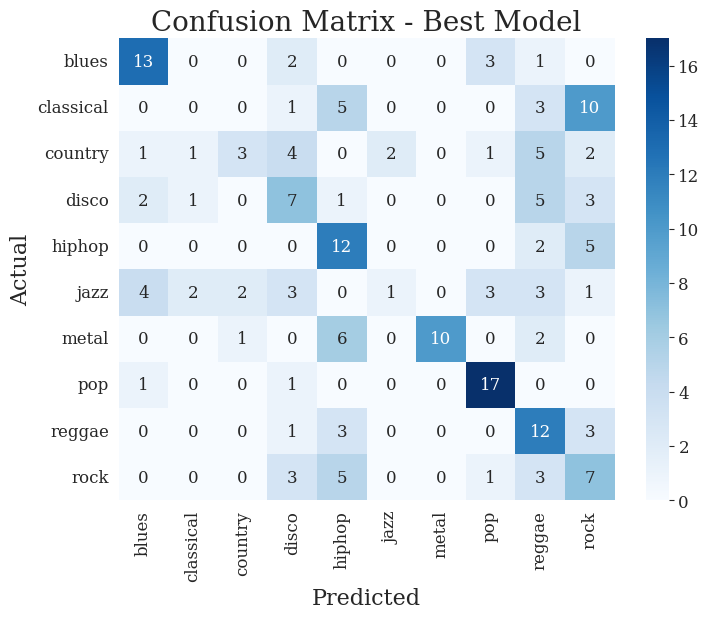

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the prediction results of the best model
best_model_predictions = cnn_model.predict(X_test)

# Converts probabilities to category labels
best_model_predictions_classes = np.argmax(best_model_predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm_best_model = confusion_matrix(true_classes, best_model_predictions_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=['blues',  'classical',  'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop',  'reggae', 'rock'],
            yticklabels=['blues',  'classical',  'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop',  'reggae', 'rock'])
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix - Best Model', fontsize=20)
plt.show()


In [ ]:
best_val_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

best_epoch = best_val_accuracy_index + 1  # Adding 1 because epochs are 1-indexed

# Print the highest val_accuracy and its corresponding epoch
print(f"Highest validation accuracy: {max(history.history['val_accuracy'])} at epoch {best_epoch}")

Highest validation accuracy: 0.4526315927505493 at epoch 15


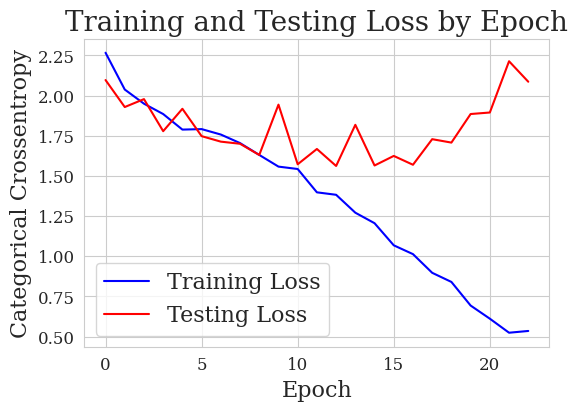

In [ ]:
# Check out the train loss and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Categorical Crossentropy', fontsize = 16)
# plt.xticks(range(1,100), range(1,100))

plt.legend(fontsize = 16)

In [ ]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 130, 58, 16)       160       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 65, 29, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 63, 27, 16)        2320      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 31, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 11, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 5, 32)         0     

Try Tanh Activation

In [ ]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k


np.random.seed(23456)

# Initiating an empty neural network
cnn_model = k.models.Sequential(name='cnn_1')

if datatype in [0, 2]:
  # Adding convolutional layer
  cnn_model.add(k.layers.Conv2D(filters=16,
                      kernel_size=(3,3),
                      activation='tanh',
                      input_shape=(128,660,1)
                      ))
  pool_size = (2, 4)

if datatype == 1:
  cnn_model.add(k.layers.Conv2D(filters=16,
                    kernel_size=(3,3),
                    activation='tanh',
                    input_shape=(132,60,1)
                    ))
  pool_size = (2, 2)

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=pool_size))

# Adding convolutional layer
cnn_model.add(k.layers.Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='tanh'))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=pool_size))

# Adding convolutional layer
cnn_model.add(k.layers.Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='tanh'))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=pool_size))

# Adding convolutional layer
cnn_model.add(k.layers.Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='tanh'))

# Adding max pooling layer
cnn_model.add(k.layers.MaxPooling2D(pool_size=pool_size))


# # Adding a flattened layer to input our image data
cnn_model.add(k.layers.Flatten())


# Adding a dense layer
cnn_model.add(k.layers.Dense(1024, activation='tanh'))

# Adding a dropout layer for regularization
cnn_model.add(k.layers.Dropout(0.25))

# Adding an output layer
cnn_model.add(k.layers.Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  # optimizer='adam',
                  optimizer=k.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

early_stopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        callbacks=[early_stopping])

TF version:- 2.14.0
Epoch 1/100
48/48 [==============================] - 2s 10ms/step - loss: 2.1854 - accuracy: 0.1792 - val_loss: 1.9133 - val_accuracy: 0.3053
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 1.8485 - accuracy: 0.3149 - val_loss: 1.8132 - val_accuracy: 0.3579
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 1.7380 - accuracy: 0.3597 - val_loss: 1.6863 - val_accuracy: 0.3632
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 1.5695 - accuracy: 0.4361 - val_loss: 1.7084 - val_accuracy: 0.3316
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 1.4416 - accuracy: 0.5231 - val_loss: 1.6443 - val_accuracy: 0.3737
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 1.2719 - accuracy: 0.5982 - val_loss: 1.8693 - val_accuracy: 0.3105
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 1.0114 - accuracy: 0.6877 - val_loss: 1.7992 - val_accuracy:

6/6 [==============================] - 0s 3ms/step


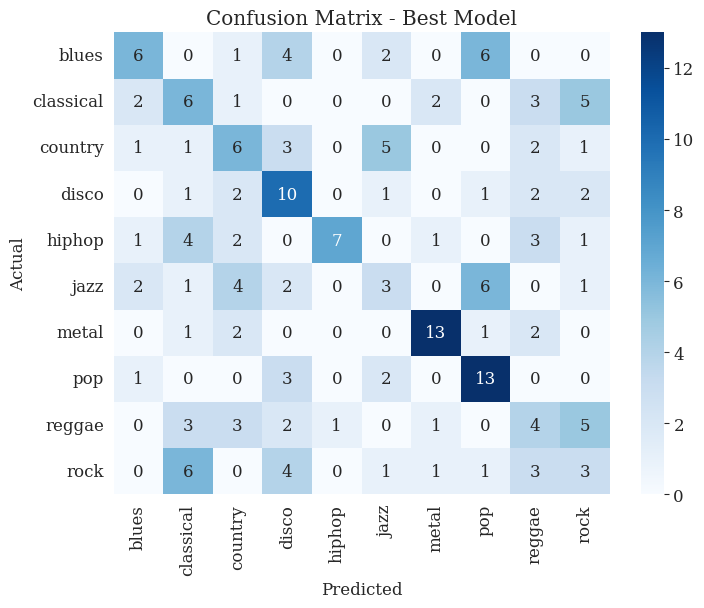

In [ ]:
# Get the prediction results of the best model
best_model_predictions = cnn_model.predict(X_test)

# Converts probabilities to category labels
best_model_predictions_classes = np.argmax(best_model_predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm_best_model = confusion_matrix(true_classes, best_model_predictions_classes)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=['blues',  'classical',  'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop',  'reggae', 'rock'],
            yticklabels=['blues',  'classical',  'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop',  'reggae', 'rock'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.show()


In [ ]:
best_val_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

best_epoch = best_val_accuracy_index + 1  # Adding 1 because epochs are 1-indexed

# Print the highest val_accuracy and its corresponding epoch
print(f"Highest validation accuracy: {max(history.history['val_accuracy'])} at epoch {best_epoch}")

Highest validation accuracy: 0.34210526943206787 at epoch 59


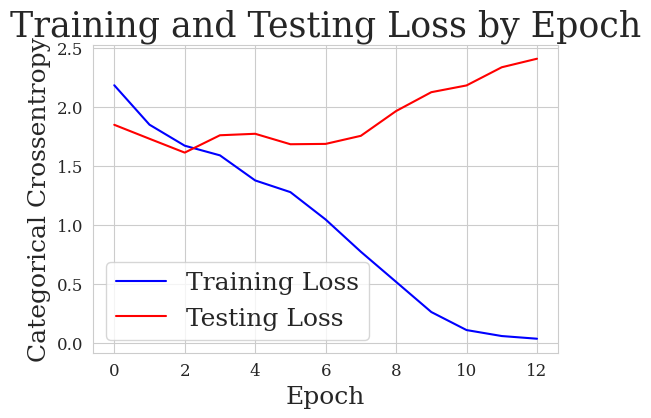

In [ ]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
# plt.xticks(range(1,100), range(1,100))

plt.legend(fontsize = 18)

In [ ]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 130, 58, 16)       160       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 65, 29, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 63, 27, 16)        2320      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 31, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 29, 11, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 14, 5, 32)         0     